# 猫狗大战（Dogs vs Cats）

## 项目介绍

**TODO：介绍Dogs vs Cats 项目的背景**

## 项目内容

* [Step0](#step0): 导入数据集
* [Step1](#step1): 数据分析
* [Step2](#step2): 模型预测
* [Step3](#step3): 结果分析
 
<a id="step0"></a>
## 1. 导入数据集

读取datas目录下的数据集，并分为train和test两类。

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

data = load_files('datas')

files = np.array(data['filenames'])
targets = np.array(data['target'])
target_names = np.array(data['target_names'])

train_files = [files[idx] for idx in range(len(files)) if targets[idx] == np.argwhere(target_names == 'train')]
test_files = [files[idx] for idx in range(len(files)) if targets[idx] == np.argwhere(target_names == 'test')]

print("There are {} train images.".format(len(train_files)))
print("There are {} test images.".format(len(test_files)))

Using TensorFlow backend.


There are 25000 train images.
There are 12500 test images.


可视化训练数据集中前12张图片。

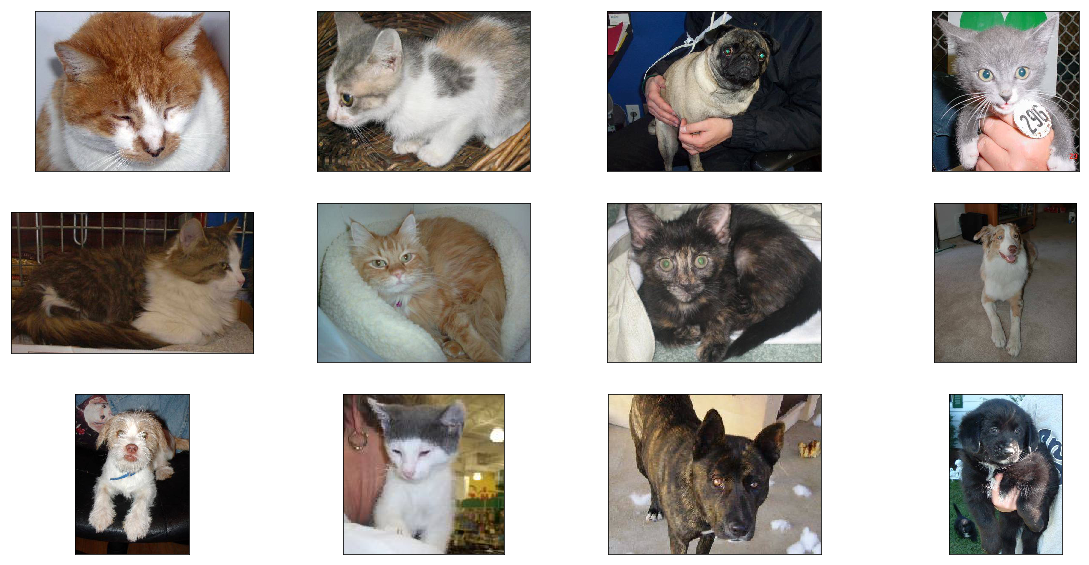

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)

<a id="step1"></a>
## 2. 数据分析

### 2.1 提取数据特征

通过查看训练数据集，发现数据集的标注信息是定义在文件名的，从文件名中提取对应的数据特征，如下表：

|文件|标注（dog）|标注（cat）|
|-|-|-|
|datas/train/cat.6938.jpg  |0|1|
|datas/train/dog.11432.jpg |1|0|
|datas/train/cat.433.jpg   |0|1|
|datas/train/cat.11305.jpg |0|1|


In [3]:
data_labels = ("dog", "cat")

train_labels = []
for file in train_files:
    for idx in range(len(data_labels)):
        if data_labels[idx] in file:
            train_labels.append(idx)

train_targets = np_utils.to_categorical(np.array(train_labels), 2)
print("The first 5 train file:\n{}\n".format(train_files[0:5]))
print("The first 5 train targets:\n{}\n".format(train_targets[0:5]))

The first 5 train file:
['datas/train/cat.9436.jpg', 'datas/train/cat.6938.jpg', 'datas/train/dog.11432.jpg', 'datas/train/cat.10939.jpg', 'datas/train/cat.433.jpg']

The first 5 train targets:
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]



## 2.2 数据处理

根据文件名，读取图片文件中的数据

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# 加载图片资源
train_tensors = paths_to_tensor(train_files)
test_tensors = paths_to_tensor(test_files)

100%|██████████| 12500/12500 [00:35<00:00, 354.94it/s]


### 2.2 验证集划分

从sklearn.model_selection中导入train_test_split
将train_files和train_targets作为train_test_split的输入变量
设置test_size为0.2，划分出20%的验证集，80%的数据留作新的训练集。
设置random_state随机种子，以确保每一次运行都可以得到相同划分的结果。（随机种子固定，生成的随机序列就是确定的）

In [6]:
from sklearn.model_selection import train_test_split

X_train , X_valid , y_train, y_valid = train_test_split(train_tensors, train_targets, test_size=0.2, random_state=100)

print("Splited train set num: {}".format(len(X_train)))
print("Splited valid set num: {}".format(len(X_valid)))

Splited train set num: 20000
Splited valid set num: 5000


<a id="step2"></a>
## 3. 模型预测

基于[Deep Residual Networks](https://github.com/KaimingHe/deep-residual-networks#models) 来创建CNN模型。

**TODO: 介绍为什么使用ResNet-50，以及ResNet模型的原理**

### 3.1 构建模型

为了提高模型的训练速度和质量，这里使用迁移学习，主要构建全连接层模型。

In [10]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(1, 1, 2048)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 4,098.0
Trainable params: 4,098.0
Non-trainable params: 0.0
_________________________________________________________________


## 3.2 训练模型

使用构建好的ResNet50模型进行训练，并将训练的权重保存到hdf5文件中。

In [8]:
# 加载已生成的bottleneck features
bottleneck_features = np.load('bottlenecks/bottlenecks_resnet50.npz')
train_bottleneck = bottleneck_features['train']
valid_bottleneck = bottleneck_features['valid']
test_bottleneck = bottleneck_features['test']

In [11]:
from keras.callbacks import ModelCheckpoint

# 训练全连接层网络模型
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_resnet50.hdf5', verbose=1, save_best_only=True)
history = model.fit(train_bottleneck, y_train, validation_data=(valid_bottleneck, y_valid),
        epochs=30, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 4s - loss: 0.0549 - acc: 0.9804 - val_loss: 0.0349 - val_acc: 0.9874
Epoch 2/30
20000/20000 [==============================] - 2s - loss: 0.0342 - acc: 0.9882 - val_loss: 0.0421 - val_acc: 0.9862
Epoch 3/30
20000/20000 [==============================] - 2s - loss: 0.0289 - acc: 0.9914 - val_loss: 0.0357 - val_acc: 0.9892
Epoch 4/30
20000/20000 [==============================] - 2s - loss: 0.0259 - acc: 0.9917 - val_loss: 0.0379 - val_acc: 0.9884
Epoch 5/30
20000/20000 [==============================] - 2s - loss: 0.0238 - acc: 0.9927 - val_loss: 0.0466 - val_acc: 0.9858
Epoch 6/30
20000/20000 [==============================] - 2s - loss: 0.0212 - acc: 0.9931 - val_loss: 0.0418 - val_acc: 0.9864
Epoch 7/30
20000/20000 [==============================] - 2s - loss: 0.0201 - acc: 0.9941 - val_loss: 0.0532 - val_acc: 0.9860
Epoch 8/30
20000/20000 [==============================] - 2s -

将模型的训练过程进行可视化。

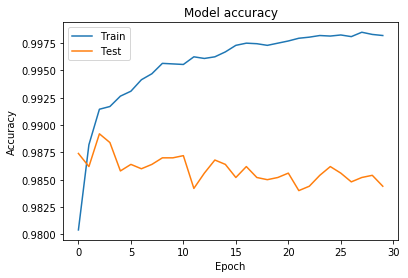

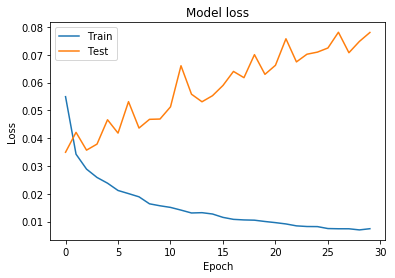

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## 3.3 验证模型

根据测试集中的数据进行预测。

In [14]:
# Load trained model weights
model.load_weights('saved_models/weights_best_resnet50.hdf5')

# Predict test set
test_predict = [np.argmax(model.predict(np.expand_dims(feature, axis=0), verbose=1)) for feature in test_bottleneck]

1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


将部分预测的结果进行可视化预览

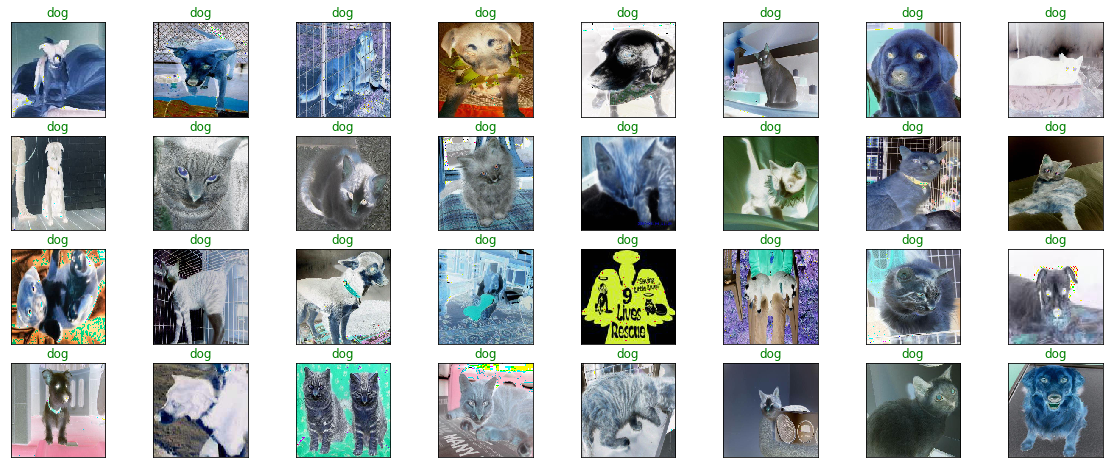

In [15]:
# plot a random sample of test images, their predicted labels
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(test_tensors.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_tensors[idx]))
    pred_idx = np.argmax(test_predict[idx])
    ax.set_title("{}".format(data_labels[pred_idx]), color=("green"))

将预测的结果提交到kaggle，以便得到模型的准确率排名。

In [16]:
import pandas as pd

## 加载结果格式
submit_frame = pd.read_csv("submission/sample_submission.csv")
## 保存结果
submit_frame['label'] = test_predict
test_result_name = "submission/submission.csv"
submit_frame[['id','label']].to_csv(test_result_name,index=False)

<a id="step3"></a>
## 4. 结果分析

### 4.1 测试模型

**TODO: 分析算法的不足，提供优化建议，并提供参数优化后的结果**

In [ ]:
# model.load_weights('saved_models/weights.best.Resnet50.hdf5')

# Resnet50_predict = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# print("The first 5 train targets:\n{}\n".format(train_targets[0:5]))

### 4.2 提交结果

In [ ]:
# ## 加载结果格式
# submit_frame = pd.read_csv("sample_submission.csv")
# ## 保存结果
# result = pd.merge(submit_frame, test_content, on="id", how='left')
# result = result.rename(index=str, columns={"cuisine_y": "cuisine"})
# test_result_name = "tfidf_cuisine_test.csv"
# result[['id','cuisine']].to_csv(test_result_name,index=False)